In [7]:
## NOTES:
# pip install pytorch-lightning==1.5.10 
# use version 1.5.10  -> optimizer idx depreciated in newer versions

# apparently dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# num_workers > 0 does not work in jupyter vs code in windows

# Default Data Type: PyTorch layers and operations are optimized for torch.float32.

In [8]:
import os
import numpy as np
import cv2
# from PIL import Image
# from IPython.display import display, Image
import matplotlib.pyplot as plt
import random


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchsummary import summary

import pytorch_lightning as pl


In [9]:
torch.cuda.empty_cache()

In [10]:
BATCH_SIZE = 50
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count()/2)
print("AVAIL_GPUS :",AVAIL_GPUS)
print("NUM_WORKERS :",NUM_WORKERS)

AVAIL_GPUS : 1
NUM_WORKERS : 4


In [11]:
# Train_Folder ='./Dataset/Train/'
Train_Folder ='C:/Users/kevr0/OneDrive/Desktop/CPS-584/sculpture/Landscape/train1'
image_files= [f for f in os.listdir(Train_Folder) if f.endswith('.jpg')]


In [12]:
sketch_list = []
image_list = []

def generate_image(image_path):
    og_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    n_image = cv2.resize(og_image, (128, 128))
    n_image = n_image/255.0
    n_image = n_image.astype(np.float32)
    return n_image

def generate_outline(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    n_image = cv2.resize(image, (256, 256))
    blurred = cv2.GaussianBlur(n_image, (3, 3), 1)
    edges = cv2.Canny(blurred, 30, 60)
    inverted_edges = cv2.bitwise_not(edges)
    resized_image = cv2.resize(inverted_edges, (128, 128))
    
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
    
    gray_image_final = rgb_image/255.0
    # gray_image_final = np.expand_dims(gray_image_final, axis=-1)
    gray_image_final = gray_image_final.astype(np.float32)
    return gray_image_final

for image_file in image_files:
    image_path = os.path.join(Train_Folder, image_file)
    image_list.append(generate_image(image_path))
    sketch_list.append(generate_outline(image_path))
    
sketch_list[1].shape

(128, 128, 3)

In [13]:
image_list[1].shape

(128, 128, 3)

In [14]:
print(len(image_list))
print(len(sketch_list))

3390
3390


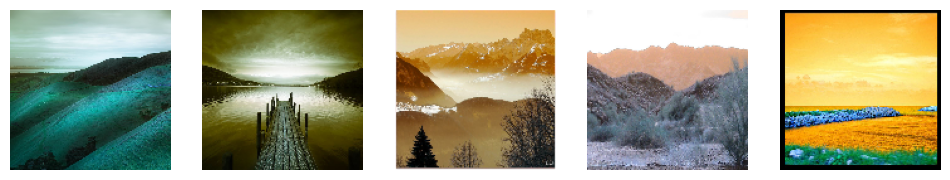

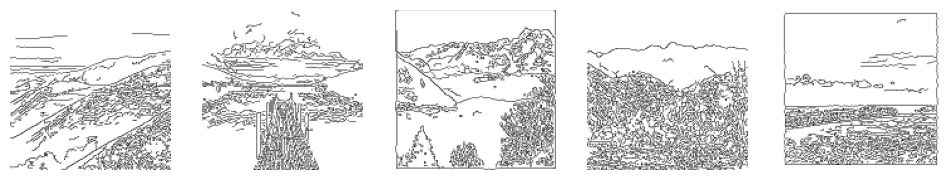

In [15]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_list[i], cmap='gray')
    plt.axis('off')
plt.show()
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sketch_list[i], cmap='gray')
    plt.axis('off')
plt.show()

In [16]:

class ImageSketchDataset(Dataset):
    def __init__(self, images, sketches, transform):
        self.images = images
        self.sketches = sketches
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        sketch = self.sketches[idx]
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            sketch = self.transform(sketch)
        
        return {'image': image, 'sketch': sketch}

# Convert images and sketches to PyTorch tensors
transform = ToTensor()

# Create the dataset
dataset = ImageSketchDataset(image_list, sketch_list, transform=transform)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [17]:
# sketch_to_gen = []
# for sketch in sketch_list:
#     sketch_to_gen.append(transform(sketch))
# sketch_to_gen

In [18]:
# img_list = []
# for img in image_list:
#     img_list.append(transform(img))
# img_list

In [19]:
for batch in dataloader:
    images = batch['image']
    sketches = batch['sketch']
    print('Batch of images shape:', images.shape)
    print('Batch of sketches shape:', sketches.shape)
    break

Batch of images shape: torch.Size([50, 3, 128, 128])
Batch of sketches shape: torch.Size([50, 3, 128, 128])


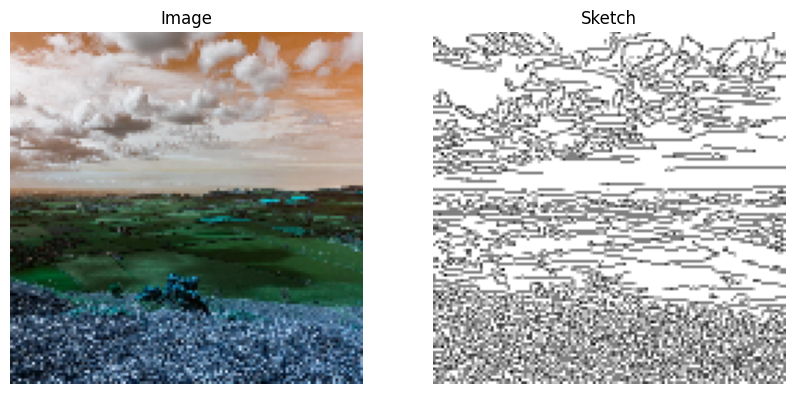

In [20]:
for batch in dataloader:
    images = batch['image']
    sketches = batch['sketch']
    break

# Select the first image and sketch from the batch
image = images[0].numpy().transpose(1, 2, 0)  # Convert from CHW to HWC format
sketch = sketches[0].numpy().transpose(1, 2, 0)  # Remove single-channel dimension if necessary

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the image
ax[0].imshow(image)
ax[0].set_title('Image')
ax[0].axis('off')

# Display the sketch
# ax[1].imshow(sketch, cmap='gray')
ax[1].imshow(sketch)
ax[1].set_title('Sketch')
ax[1].axis('off')

plt.show()

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Conv2d
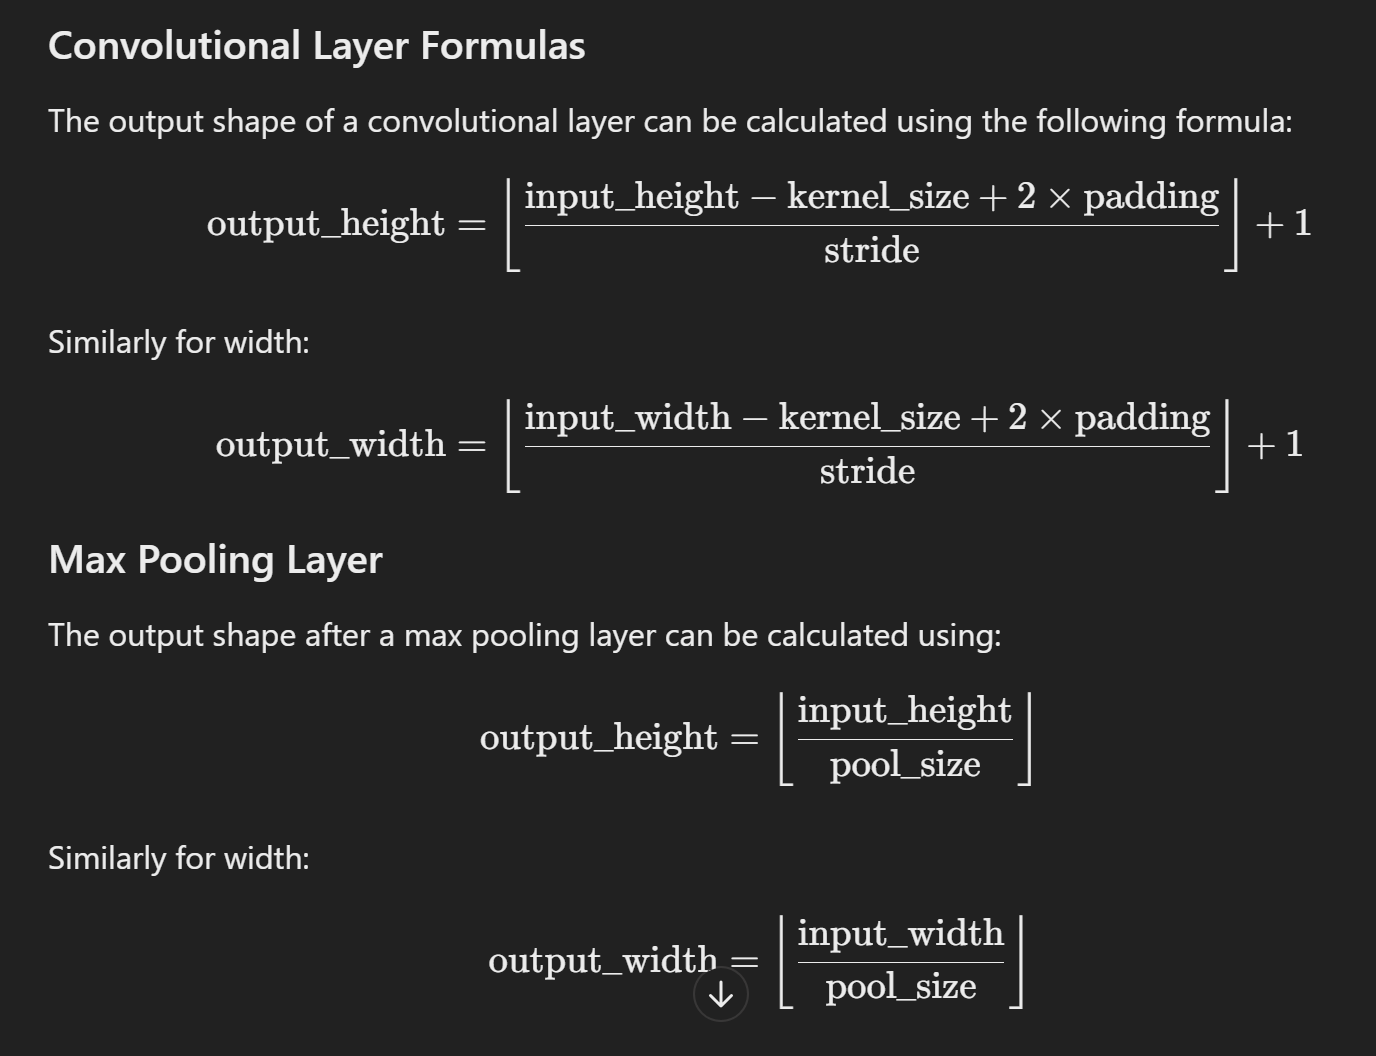

Used to flatten: value needs to be even?
x.view(-1, 64*64)


In [22]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=1, padding=2)
#         self.conv2 = nn.Conv2d(128, 64, kernel_size=4, stride=1, padding=2)
#         self.conv2_drop = nn.Dropout2d(p = 0.2)
#         self.fc1 = nn.Linear(64*32*32, 2048)
#         self.fc2 = nn.Linear(2048,50)
#         self.fc3 = nn.Linear(50,1)
    
#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         # x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         x = x.view(-1, 64*32*32)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = F.relu(self.fc2(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc3(x)

#         return torch.sigmoid(x)



In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=7, stride=1, padding=0)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=0)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        
        self.fc1 = nn.Linear(256*3*3, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)
        # self.fc4 = nn.Linear(16,1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.max_pool2d(x, 2)
        
        # print("Shape before flattening:", x.shape)
        x = torch.flatten(x, 1)
        # print("Shape after flattening:", x.shape)
        # x = x.view(-1, 4608)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x



In [24]:
# discriminator = Discriminator().to(device)
# # print(discriminator(z))
# print(summary(discriminator, (3, 128, 128)))

# ConvTranspose2d
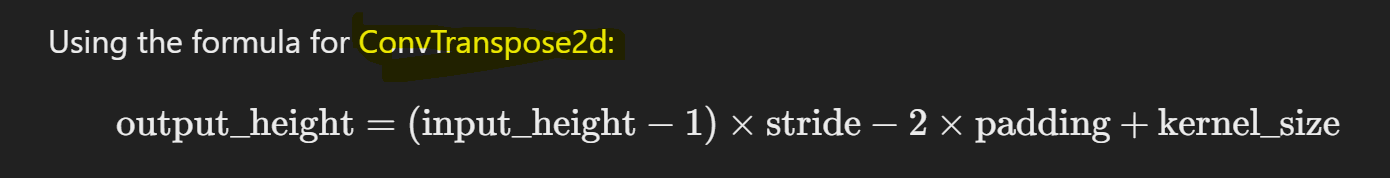
output_height=(input_height−1)×stride−2×padding+kernel_size
output_height=output_width

for :: nn.ConvTranspose2d(1, 64, kernel_size=4, stride=2, padding=1) 
will give output :: 64, output_height, output_width

if :: input = 1,128,128
then :: input_height = 128

In [25]:
# class Generator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv2_drop = nn.Dropout2d(p = 0.2)
#         self.ct1 = nn.ConvTranspose2d(3, 128, kernel_size=4, stride=2, padding=1) 
#         self.ct2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
#         self.ct3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=1, padding=2)
#         self.ct4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=1, padding=1)
        
#     def forward(self, x):
#         # Forward pass through the network
#         x = F.relu(self.ct1(x))
#         x = self.conv2_drop(self.ct2(x))
#         x = F.relu(F.max_pool2d(x, 2))
#         x = self.conv2_drop(self.ct3(x))
#         x = F.relu(F.max_pool2d(x, 2))
#         x = F.relu(self.ct4(x))
#         x = torch.tanh(x)
#         return x    


In [26]:
# z = random.choice(sketch_to_gen)
# z = z.unsqueeze(0)
# print(z)
# z = z.to(torch.float32)
# print(z)

In [27]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2_drop = nn.Dropout2d(p = 0.1)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        
        self.conv4 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=0)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        
        self.conv7 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=0)
        self.conv8 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        
        self.ct1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0) 
        self.ct2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=0)
        self.ct3 = nn.ConvTranspose2d(64, 64, kernel_size=5, stride=1, padding=0)
        
        self.ct4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=0)
        self.ct5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=0)
        self.ct6 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=1, padding=0)
         
        self.ct7 = nn.ConvTranspose2d(64, 16, kernel_size=3, stride=1, padding=0)
        self.ct8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=0)
        self.ct9 = nn.ConvTranspose2d(3, 3, kernel_size=5, stride=1, padding=0)
        
    def forward(self, x):
        # Forward pass through the network
        x1 = F.leaky_relu(self.conv1(x))
        x1 = F.leaky_relu(self.conv2(x1))
        x1 = F.leaky_relu(self.conv3(x1)) #32
        
        x2 = F.leaky_relu(self.conv4(x1))
        x2 = F.leaky_relu(self.conv5(x2))
        x2 = F.leaky_relu(self.conv6(x2)) #64
        
        x3 = F.leaky_relu(self.conv7(x2))
        x3 = F.leaky_relu(self.conv8(x3))
        x3bottle = self.conv9(x3)
        x3 = F.leaky_relu(x3bottle) #128
   
        bottleneck = torch.tanh(x3bottle) #128
        
        concat1 = torch.cat([bottleneck, x3], dim=1) #128+128
        xt3 = F.relu(self.ct1(concat1))
        xt3 = F.relu(self.ct2(xt3))
        xt3 = F.relu(self.ct3(xt3))         # 64
        
        concat2 = torch.cat([xt3, x2], dim=1) #64 +64
        xt2 = F.relu(self.ct4(concat2))
        xt2 = F.relu(self.ct5(xt2))
        xt2 = F.relu(self.ct6(xt2))  #32
        
        concat3 = torch.cat([xt2, x1], dim=1)  #32+32
        xt1 = F.relu(self.ct7(concat3))
        xt1 = F.relu(self.ct8(xt1))
        xt1 = F.sigmoid(self.ct9(xt1))
    
        return xt1   

In [28]:
# generator = Generator().to(device)
# # print(generator(z).shape)
# print(summary(generator, (3, 128, 128)))

In [29]:
# class GAN(pl.LightningModule):
#     def __init__(self, latent_dim=100, lr=0.0002):
#         super().__init__()
#         self.save_hyperparameters()
#         self.generator = Generator().to(self.device)
#         self.discriminator = Discriminator().to(self.device)

#     def forward(self, z):
#         return self.generator(z)
    
#     def adversarial_loss(self, y_hat, y):
#         return F.binary_cross_entropy(y_hat, y)
    
#     def training_step(self, batch, batch_idx, optimizer_idx):
#         real_imgs = batch['image'].to(self.device)
#         z = batch['sketch'].to(self.device)

#         # Train Generator
#         if optimizer_idx == 0:
#             fake_imgs = self(z)
#             y_hat = self.discriminator(fake_imgs)
#             # y = self.discriminator(real_imgs)
#             y = torch.ones(y_hat.size(0),1)
#             y = y.type_as(y_hat)
#             g_loss = self.adversarial_loss(y_hat, y)
#             # g_loss = self.adversarial_loss(y_hat, real_imgs)
#             log_dict = {"g_loss": g_loss.detach()}
#             return {"loss":g_loss, "progress_bar":log_dict, "log":log_dict}

#         # Train Discriminator
#         if optimizer_idx == 1:
#             # Labeling real images as real
#             y_hat_real = self.discriminator(real_imgs)
#             y_real = torch.ones(y_hat_real.size(0),1)
#             y_real = y_real.type_as(y_hat_real)
#             real_loss = self.adversarial_loss(y_hat_real, y_real)
#             # Labeling fake images as fake
#             y_hat_fake = self.discriminator(self(z).detach())
#             y_fake = torch.zeros(y_hat_fake.size(0),1)
#             y_fake = y_fake.type_as(y_hat_fake)

#             fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

#             d_loss = (real_loss + fake_loss)/2

#             log_dict = {"d_loss": d_loss}
#             return {"loss":d_loss, "progress_bar":log_dict, "log":log_dict}


#     def configure_optimizers(self):
#         lr = self.hparams.lr
#         opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
#         opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
#         return [opt_g, opt_d], []
    
#     def plot_imgs(self, dataloader):
#         for batch in dataloader:
#             sketches = batch['sketch'].to(self.device)
#             break
#         sample_imgs = self(sketches).cpu()  # Generate images and move to CPU
#         print('\nepoch ', self.current_epoch)
#         fig = plt.figure()
#         for i in range(sample_imgs.size(0)):
#             plt.subplot(2, 3, i+1)
#             plt.tight_layout()
#             plt.imshow(sample_imgs.detach()[i].permute(1,2,0), interpolation='none')
#             plt.title("Generated Data" )
#             plt.xticks([])
#             plt.yticks([])
#             plt.axis('off')
#         plt.show()
    
#     def on_epoch_end(self):
#         # if (self.current_epoch + 1) % 10 == 0:
#         self.plot_imgs(dataloader)

In [30]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator().to(self.device)
        self.discriminator = Discriminator().to(self.device)
        self.mse = nn.MSELoss()

    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def generator_loss(self, fake_output, real_y):
        return self.mse(fake_output, real_y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs = batch['image'].to(self.device)
        sketches = batch['sketch'].to(self.device)

        # Train Generator
        if optimizer_idx == 0:
            fake_imgs = self(sketches)
            # g_loss = self.adversarial_loss(fake_imgs, real_imgs)
            g_loss = self.generator_loss(fake_imgs, real_imgs)
            # y_hat = self.discriminator(fake_imgs)
            # y = torch.ones(y_hat.size(0),1)
            # y = y.type_as(y_hat)
            # g_loss = self.adversarial_loss(y_hat, y)
            
            log_dict = {"g_loss": g_loss.detach()}
            self.log("g_loss", g_loss, prog_bar=True, logger=True)
            return {"loss":g_loss, "progress_bar":log_dict, "log":log_dict}

        # Train Discriminator
        if optimizer_idx == 1:
            ### Labeling real images as real
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones(y_hat_real.size(0),1)
            y_real = y_real.type_as(y_hat_real)
            # adding noise
            y_real = y_real - (torch.rand(y_real.shape)*0.05).to(self.device)
            real_loss = self.adversarial_loss(y_hat_real, y_real)

            ### Labeling fake images as fake
            y_hat_fake = self.discriminator(self(sketches))
            y_fake = torch.zeros(y_hat_fake.size(0),1)
            y_fake = y_fake.type_as(y_hat_fake)
            # adding noise
            y_fake = y_fake + (torch.rand(y_fake.shape)*0.05).to(self.device)
            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

            d_loss = (real_loss + fake_loss)/2

            log_dict = {"d_loss": d_loss}
            self.log("d_loss", d_loss, prog_bar=True, logger=True)
            return {"loss":d_loss, "progress_bar":log_dict, "log":log_dict}


    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    def plot_imgs(self, dataloader):
        for batch in dataloader:
            sketches = batch['sketch'].to(self.device)
            break
        sample_imgs = self(sketches).cpu()  # Generate images and move to CPU
        print('\nepoch ', self.current_epoch)
        fig = plt.figure()
        num_imgs = min(sample_imgs.size(0), 6)
        for i in range(num_imgs):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i].permute(1,2,0), interpolation='none')
            plt.title("Generated Data" )
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()
    
    def on_epoch_end(self):
        if (self.current_epoch + 1) % 50 == 0:
            self.plot_imgs(dataloader)


epoch  0


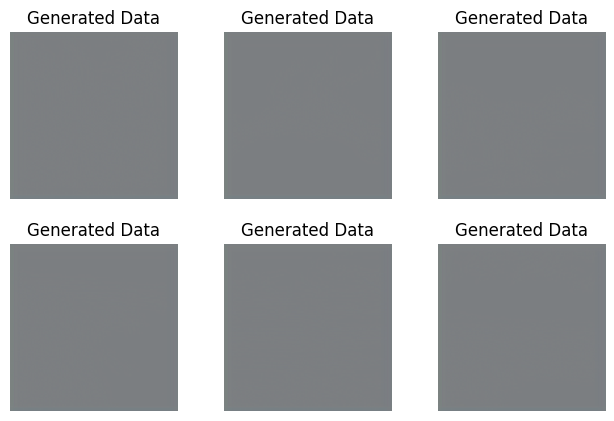

: 

In [31]:
model = GAN()
model.plot_imgs(dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 1.0 M 
1 | discriminator | Discriminator | 2.5 M 
2 | mse           | MSELoss       | 0     
------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.190    Total estimated model params size (MB)
c:\Users\kevr0\anaconda3\envs\datascience\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   1%|▏         | 1/68 [00:16<18:07, 16.23s/it]

c:\Users\kevr0\anaconda3\envs\datascience\lib\site-packages\pytorch_lightning\loops\optimization\closure.py:35: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


Epoch 49: 100%|██████████| 68/68 [19:09<00:00, 16.90s/it, loss=0.0914, v_num=8, g_loss=0.0613, d_loss=0.129] 
epoch  49


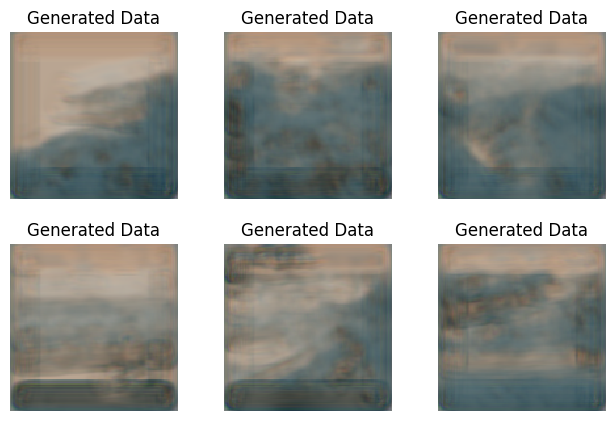

Epoch 99: 100%|██████████| 68/68 [19:04<00:00, 16.84s/it, loss=0.0973, v_num=8, g_loss=0.0578, d_loss=0.120] 
epoch  99


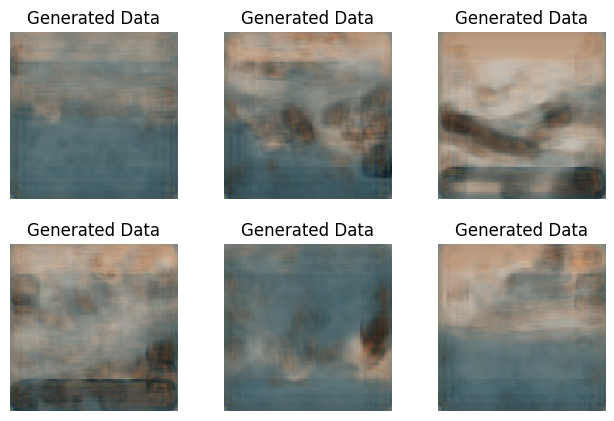

Epoch 149: 100%|██████████| 68/68 [19:01<00:00, 16.79s/it, loss=0.0861, v_num=8, g_loss=0.0512, d_loss=0.124] 
epoch  149


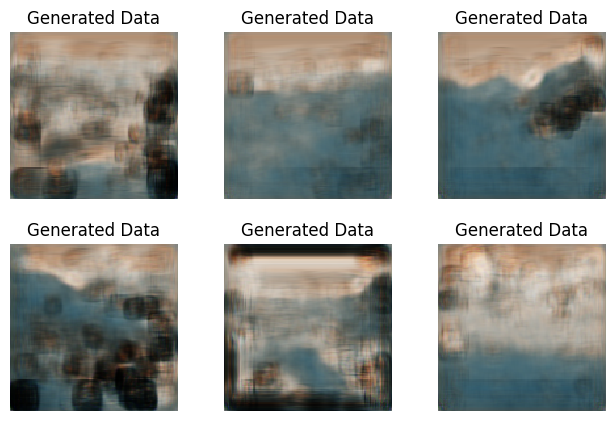

Epoch 177:  56%|█████▌    | 38/68 [10:37<08:22, 16.77s/it, loss=0.0871, v_num=8, g_loss=0.0427, d_loss=0.129] 

In [32]:

# trainer = pl.Trainer(max_epochs=1000, gpus=AVAIL_GPUS, log_every_n_steps=5)
trainer = pl.Trainer(max_epochs=2000, gpus=AVAIL_GPUS)
# trainer = pl.Trainer(max_epochs=20)

trainer.fit(model,dataloader)